# Project 1

In [282]:
# Import the dependencies
import time

import matplotlib.pyplot as plt
import cv2 as cv
from math import atan, degrees
from numba import jit
from numpy import argmin, array, exp, ma, nonzero, histogram, round
from pandas import DataFrame
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, completeness_score, accuracy_score
from sklearn.model_selection import train_test_split
from tslearn.clustering import KernelKMeans

In [105]:
# Some help functions
def log(msg):
    t = time.localtime()
    curr_time = time.strftime("%H:%M:%S", t)
    print(curr_time, msg)


def scores(true_labels, labels):
    hom = homogeneity_score(true_labels, labels)
    com = completeness_score(true_labels, labels)
    acc = accuracy_score(true_labels, labels)
    return hom, com, acc


def showCentroids(c):
    print('Centroids:')
    plt.figure(figsize=(20, 10))
    if isinstance(c, DataFrame):
        c = c.to_numpy()
    for i, x in enumerate(c):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x.reshape(28, 28))
        plt.axis('off')
    plt.show()


def show10(X, y):
    K = 10

    # For each digit 0, ..., 9, retrieve 10 samples
    plt.figure(figsize=(10, 10))
    n = 1
    for k in range(K):
        Xk = X.loc[y == k].sample(K)
        for i, x in Xk.iterrows():
            plt.subplot(10, 10, n)
            plt.imshow(x.values.reshape(28, 28))
            plt.axis('off')
            n += 1
    plt.show()

In [8]:
# Load the data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)

In [4]:
# Split the data set into a training & validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.99)
log("Let us train using " + str(len(X_train)) + " samples.")

# Remove the original indices & scale X
X_train = X_train.reset_index(drop=True) / 255
y_train = y_train.astype('int').reset_index(drop=True)

# Just an impression of the data contents (labels)
print('Frequency per label:\n', y_train.value_counts())

21:57:58 Let us train using 700 samples.
Frequency per label:
 1    79
7    73
3    71
2    70
9    70
0    69
6    69
4    68
8    68
5    63
Name: class, dtype: int64


## Exercise 1a

In [85]:
# @jit(nopython=True, parallel=True)
def kMeans(X, y_true, K: int, metric: str):
    log('Starting K-means clustering using the metric \'%s\'' % metric)
    
    # Randomly initialize the centroids c
    N, M = X.shape
    X = DataFrame(data=X)
    c = X.sample(K).reset_index(drop=True)
    y = [-1] * N  # Labels

    ePrev = M * N + 1
    eNew = ePrev - 1
    while ePrev - eNew > 0:
        ePrev = eNew
        eNew = 0

        # Assign x_i to cluster k = argmin_j || x_i - c_j ||
        for i, x in X.iterrows():
            if metric == 'gauss':
                gamma = .05
                dists = cdist([x.array], c, 'sqeuclidean')
                dists = exp(-gamma * dists)
            else:
                dists = cdist([x.array], c, metric)
            y[i] = argmin(dists)

        # Update the centroid positions
        for k in range(K):
            Ck = X.loc[[i for i, yi in enumerate(y) if yi == k]]  # Compute Ck = {x_i where the label y_i = k}
            if len(Ck) > 0:
                c.loc[k] = Ck.mean()                            # Centroid = the mean of the elements in Ck
                eNew += cdist([c.loc[k]], Ck).sum()             # Compute the error
            else:
                # Try to find a good position for this centroid
                c.loc[k] = c.mean()
    
    # Determine the accuracy
    a = 0
    for k in range(K):
        Lk = y_true.loc[[i for i, yi in enumerate(y) if yi == k]]  # Lk = {y_true_i : y_i = k}
        Lk = DataFrame(data=Lk)
        cnt = Lk.value_counts()
        cnt = cnt.values
        if len(cnt) > 0:
            a += cnt[0]
    a /= N
    
#     showCentroids(c)

    return y, a  # Return the labels

In [106]:
def doCluster(X, y):
    K = 10
    
    def A(kmeans):
        c = kmeans.cluster_centers_
        y_found = kmeans.labels_
        s = 0
        for k in range(K):
            df = DataFrame(data=y[y_found == k])
            cnt = df.value_counts()
            s += cnt.values[0]
        return s / len(X)
    
    
    # Apply the K-means clustering algorithm using the square Euclidean distance measure
    start = time.time()
#     XX = X.to_numpy
    myLabels, a1 = kMeans(X, y, K, 'sqeuclidean')
    t1 = time.time() - start
    myScore = scores(y, myLabels)
    
    # Use correlation as distance measure
    start = time.time()
    myLabels2, a2 = kMeans(X, y, K, 'correlation')
    t2 = time.time() - start
    myScore2 = scores(y, myLabels2)
    
    # Use the Gaussian distance measure
    start = time.time()
    myLabels3, a3 = kMeans(X, y, K, 'gauss')
    t3 = time.time() - start
    myScore3 = scores(y, myLabels3)

    # Use an existing algorithm
    start = time.time()
#     kmeans = KMeans(n_clusters=K, random_state=1).fit(X)
    kmeans = KMeans(n_clusters=K, init='k-means++').fit(X)  # Slight speedup
    t = time.time() - start
    score = scores(y, kmeans.labels_)
    
    # Print the results
    log('Results:\nAlgorithm \tHomogeneity Completeness   Accuracy   Time [s]\n'
        'My K-Means \t%11.4f %12.4f %10.1f%% %9.3f' % (myScore[0], myScore[1], a1*100, t1) +
        '\nMy K-Means corr.%11.4f %12.4f %10.1f%% %9.3f' % (myScore2[0], myScore2[1], a2*100, t2) +
        '\nMy K-Means gauss.%10.4f %12.4f %10.1f%% %9.3f' % (myScore3[0], myScore3[1], a3*100, t3) +
        '\nExist. K-Means\t%11.4f %12.4f %10.1f%% %9.3f' % (score[0], score[1], A(kmeans)*100, t))
    
    showCentroids(kmeans.cluster_centers_)

14:19:05 Starting K-means clustering using the metric 'sqeuclidean'
14:19:06 Starting K-means clustering using the metric 'correlation'
14:19:09 Starting K-means clustering using the metric 'gauss'
14:19:11 Results:
Algorithm 	Homogeneity Completeness   Accuracy   Time [s]
My K-Means 	     0.4366       0.4598       47.6%     1.186
My K-Means corr.     0.5335       0.5380       61.1%     3.655
My K-Means gauss.    0.2284       0.3585       32.6%     0.257
Exist. K-Means	     0.4783       0.4848       53.0%     1.343
Centroids:


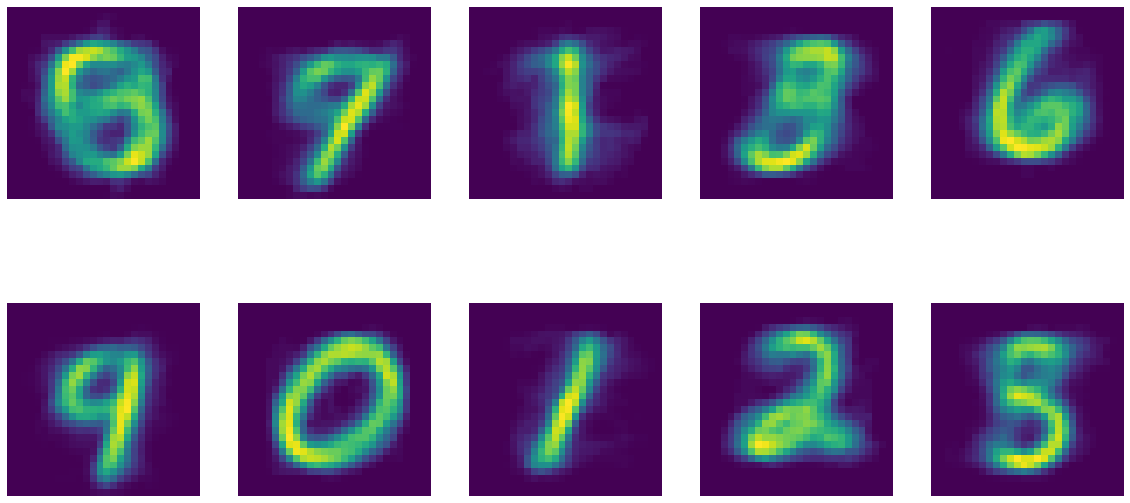

In [107]:
doCluster(X_train, y_train)

## Exercise 1b


In [314]:
def equalize(img):
    hist, bins = histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_m = ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = ma.filled(cdf_m,0).astype('uint8')
    
    return cdf[img]


def sharpen(img):
#     smoothed = cv.GaussianBlur(img, (0, 0), 3)
#     unsharped = cv.addWeighted(img, 1.5, smoothed, -0.5, 0)
    sharpen_filter = array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img = cv.filter2D(img, -1, sharpen_filter)
    
    return img


def setBounds(img):
    y = img.sum(0)
#     y[y < y.mean()] = 0
#     img[27, y > 0] = 255
    img[27, :] = y * 255 / y.max()
#     print(y)
    y = img.sum(1)
#     y[y < y.mean()] = 0
#     img[y > 0, 27] = 255
    img[:, 27] = y * 255 / y.max()
    img[27,27] = 0
    
    return img


# Based on code from https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
def fitLine(X, Y):
    xbar = sum(X) / len(X)
    ybar = sum(Y) / len(Y)
    n = len(X)

    numer = sum([xi * yi for xi, yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

#     print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))
    
    return a, b


# Rotate the given image by [angle] degrees
# Inspired by https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
def rotate(img, angle):
#     print('rotate {:.2f} deg'.format(angle))
    img_center = tuple(array(img.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(img_center, angle, 1.0)
    return cv.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv.INTER_LINEAR)


def correctRotation(img):
    nz = nonzero(img)
    df = DataFrame(data=nz)
    means = df.T.groupby(0).mean()
    inds = means.index.to_numpy()
    vals = means[1].round().astype(int).values  # The rounded values
    _, b = fitLine(inds, means[1].values)
    return rotate(img, degrees(atan(-b)))


# Define an image processing function
def procImg(img):
    img = (255 * img).astype('uint8')
    img = cv.GaussianBlur(img, (3, 3), 0)  # Blur
    img = cv.equalizeHist(img)
#     img = equalize(img)
    img = sharpen(img)
#     img = setBounds(img)
#     img[img < 80] = 0  # Threshold
#         # img = cv.Canny(img, 30, 150)    # Edge detection
        # Sum each row and put the value in the right most pixel
#         img[:,27] = sum(img, 2)
#         img[27,:] = sum(img, 1)
    img = correctRotation(img)
    
    return img.astype('float32') / 255

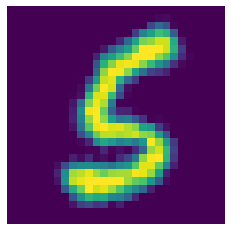

In [315]:
# Test the image processor
img = X_train.loc[10].values.reshape(28, 28)
img = procImg(img)
plt.imshow(img)
plt.axis('off')
plt.show;

In [307]:
# Process the images
def process(X):
    X_proc = X.copy()
    for i, x in X.iterrows():
        
        # Process image x
        img = x.values.reshape(28, 28)
        img = procImg(img)
        
        X_proc.loc[i] = img.reshape(784)
    return X_proc

In [316]:
X_proc = process(X_train)

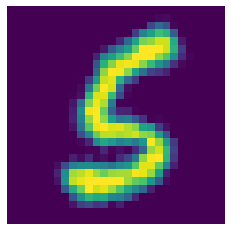

In [317]:
# Test X_proc as the result of process. Is it as expected?
img = X_proc.loc[10].values.reshape(28, 28)
plt.imshow(img)
plt.axis('off')
plt.show;

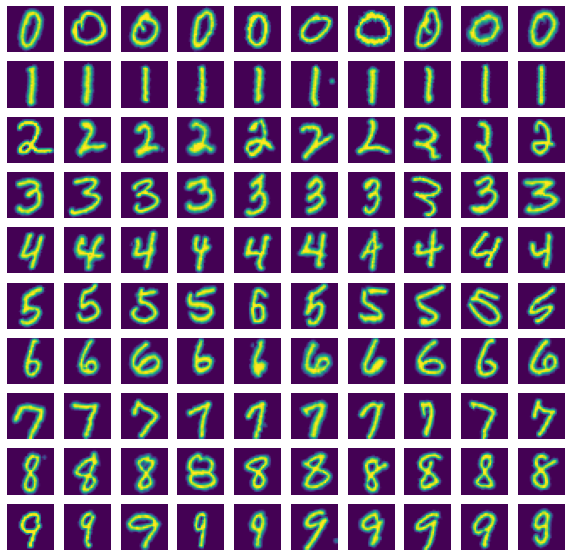

In [319]:
# Show some results
show10(X_proc, y_train)

15:25:26 Starting K-means clustering using the metric 'sqeuclidean'
15:25:28 Starting K-means clustering using the metric 'correlation'
15:25:31 Starting K-means clustering using the metric 'gauss'
15:25:32 Results:
Algorithm 	Homogeneity Completeness   Accuracy   Time [s]
My K-Means 	     0.6708       0.6854       74.3%     2.350
My K-Means corr.     0.6717       0.6840       74.0%     2.596
My K-Means gauss.    0.1160       0.2954       23.3%     0.263
Exist. K-Means	     0.6691       0.6792       73.6%     1.268
Centroids:


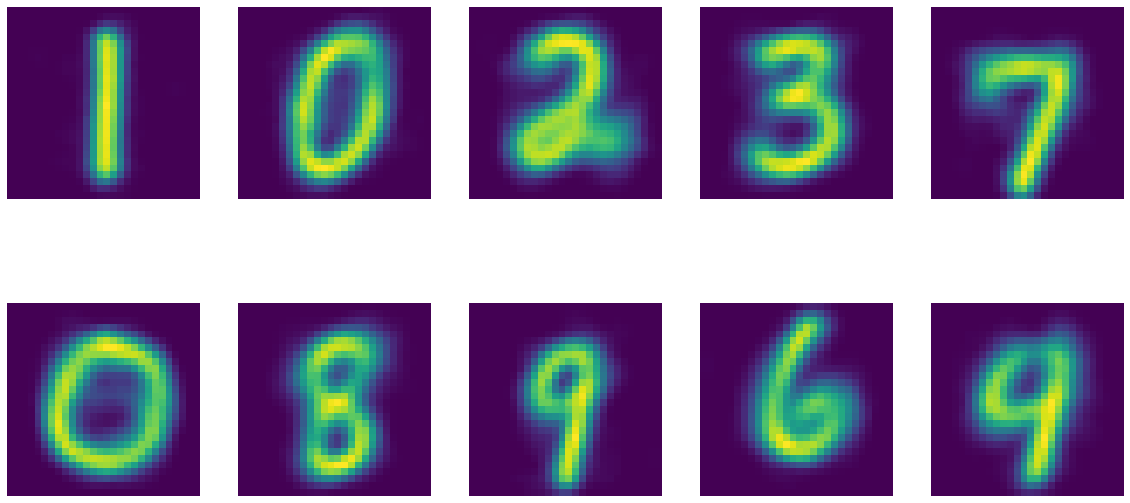

In [318]:
# Apply the clustering algorithm on the processed images
doCluster(X_proc, y_train)

In [ ]:
# Use a 
# km = KernelKMeans(n_clusters=3,
#                       kernel="gak",
#                       kernel_params={"sigma": "auto"},
#                       n_init=20,
#                       verbose=True,
#                       random_state=408431)
# y_pred = km.fit_predict(X_train)
# print(score(y, y_pred))